In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%tensorflow_version 2.x
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

Tensorflow version 2.4.1
Running on TPU  ['10.106.35.74:8470']
INFO:tensorflow:Initializing the TPU system: grpc://10.106.35.74:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.106.35.74:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


# **Import Required Libraries**

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axisartist.axislines import Subplot
from copy import copy, deepcopy
import pytz
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from scipy.stats import boxcox
from pickle import dump, load

#import tensorflow as tf
from tensorflow import GradientTape
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.metrics import RootMeanSquaredError, Mean
from tensorflow.keras.layers import Input, Dense, LSTM, Layer, Bidirectional, LayerNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.losses import huber, mse, Loss, Reduction
import tensorflow.keras.backend as K

# **Import Data**

In [5]:
trainX = load(open('/content/drive/My Drive/Colab Notebooks/Electricity Forecasting/data/trainXReadings.pkl', 'rb'))
trainY = load(open('/content/drive/My Drive/Colab Notebooks/Electricity Forecasting/data/trainYReadings.pkl', 'rb'))
testX = load(open('/content/drive/My Drive/Colab Notebooks/Electricity Forecasting/data/testXReadings.pkl', 'rb'))
testY = load(open('/content/drive/My Drive/Colab Notebooks/Electricity Forecasting/data/testYReadings.pkl', 'rb'))

scaler = load(open('/content/drive/My Drive/Colab Notebooks/Electricity Forecasting/data/scaler.pkl', 'rb'))

print(len(trainX), len(trainX))
print(trainX[0].shape, trainY[0].shape)
print(len(testX), len(testX))
print(testX[0].shape, testY[0].shape)

458598 458598
(280,) (56,)
106076 106076
(280,) (56,)


**Prepare imported data for LSTM training**

In [6]:
myTrainX = np.array(trainX)
myTrainY = np.array(trainY)
myTestX = np.array(testX)
myTestY = np.array(testY)
print("Before Reshaping")
print(myTrainX.shape, myTrainY.shape)
print(myTestX.shape, myTestY.shape)

# Reshape Input to be [Samples, Time-Steps, Features]
myTrainX = np.reshape(myTrainX, (myTrainX.shape[0], myTrainX.shape[1], 1))
myTestX = np.reshape(myTestX, (myTestX.shape[0], myTestX.shape[1], 1))
print("After Reshaping")
print(myTrainX.shape, myTrainY.shape)
print(myTestX.shape, myTestY.shape)

Before Reshaping
(458598, 280) (458598, 56)
(106076, 280) (106076, 56)
After Reshaping
(458598, 280, 1) (458598, 56)
(106076, 280, 1) (106076, 56)


In [ ]:
model = Sequential()
model.add(Input(shape=(myTrainX.shape[1], myTrainX.shape[2])))
forward_layer1 = LSTM(14, activation='tanh', return_sequences=True)
forward_layer2 = LSTM(14, activation='tanh', return_sequences=False)
backward_layer1 = LSTM(14, activation='tanh', return_sequences=True,
                       go_backwards=True)
backward_layer2 = LSTM(14, activation='tanh', return_sequences=False,
                       go_backwards=True)
model.add(Bidirectional(forward_layer1, backward_layer=backward_layer1))
#model.add(LayerNormalization())
model.add(Bidirectional(forward_layer2, backward_layer=backward_layer2))
#model.add(LayerNormalization())
model.add(Dense(myTrainY.shape[1], activation='linear'))

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-4 * 10**(epoch / 40) if (1e-4 * 10**(epoch / 20)<1e-2) else 1e-2)
adam = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath="/content/drive/My Drive/Colab Notebooks/Electricity Forecasting/weights.hdf5", monitor="loss", verbose=0, save_best_only=True, save_weights_only=True)
model.compile(loss="huber_loss",
              optimizer=adam,
              metrics=["mean_squared_error"])

model.summary()

batch_size = 500
print("Starting to fit")
history = model.fit(myTrainX, myTrainY, epochs=100, batch_size=batch_size, verbose=1, validation_split=0.1, shuffle=True, callbacks=[lr_schedule, checkpointer])
model.load_weights('/content/drive/My Drive/Colab Notebooks/Electricity Forecasting/weights.hdf5')

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_10 (Bidirectio (None, 280, 28)           1792      
_________________________________________________________________
bidirectional_11 (Bidirectio (None, 28)                4816      
_________________________________________________________________
dense_5 (Dense)              (None, 56)                1624      
Total params: 8,232
Trainable params: 8,232
Non-trainable params: 0
_________________________________________________________________
Starting to fit
Epoch 1/100
826/826 [==============================] - 298s 354ms/step - loss: 0.3914 - mean_squared_error: 0.8872 - val_loss: 0.3647 - val_mean_squared_error: 0.8168
Epoch 2/100
826/826 [==============================] - 288s 349ms/step - loss: 0.2525 - mean_squared_error: 0.5570 - val_loss: 0.3482 - val_mean_squared_error: 0.7802
Epoch 3/100
826/826 [===========

In [25]:
df = pd. read_csv("/content/drive/My Drive/Colab Notebooks/Electricity Forecasting/logs.csv", header=None)
training_loss = df[0].values
val_loss = df[1].values
# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)
# Visualize loss history
plt.figure(figsize=(10, 6))
plt.rc('font', size=20)         # controls default text sizes
plt.rc('axes', titlesize=22)    # fontsize of the axes title
plt.rc('axes', labelsize=22)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=20)   # fontsize of the tick labels
plt.rc('ytick', labelsize=20)  # fontsize of the tick labels
plt.rc('legend', fontsize=22)   # legend fontsize
plt.rc('figure', titlesize=23)  # fontsize of the figure title
plt.plot(epoch_count, training_loss, 'b--', label='Training Loss')
plt.plot(epoch_count, val_loss, 'r--', label='Validation Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.savefig("/content/drive/My Drive/Colab Notebooks/Electricity Forecasting/lossCharacteristics.pdf", bbox_inches = 'tight', pad_inches = 0.05)
plt.close()

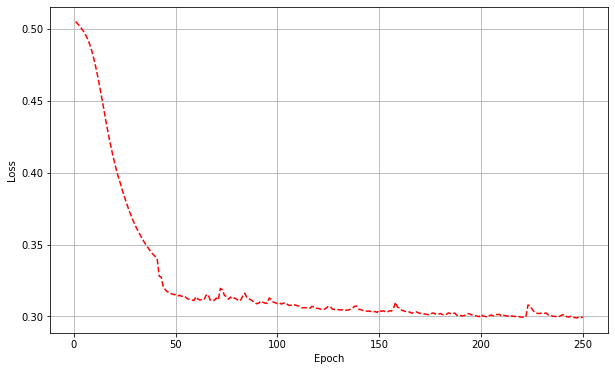

In [ ]:

# Get training and test loss histories
training_loss = history.history['loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.figure(figsize=(10, 6))
plt.plot(epoch_count, training_loss, 'r--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

In [ ]:
# Evaluate Model
print('Training Data Evaluation')
print(model.evaluate(x = myTrainX, y = myTrainY))
print('Test Data Evaluation')
print(model.evaluate(x = myTestX, y = myTestY))

Training Data Evaluation
255/255 [==============================] - 9s 35ms/step - loss: 0.2991 - mean_squared_error: 0.6557
[0.2990552484989166, 0.6557182669639587]
Test Data Evaluation
64/64 [==============================] - 2s 35ms/step - loss: nan - mean_squared_error: nan
[nan, nan]


In [ ]:
forecast = model.predict(myTrainX)
print(forecast.shape)
print(myTrainX.shape)
print(myTrainY.shape)
naive_forecast = myTrainX[:, -56:, 0]
print(naive_forecast.shape)

print('RMSE for DNN Model = ', mean_squared_error(myTrainY, forecast, squared=False))
print('RMSE for Naive Forecast = ', mean_squared_error(myTrainY, naive_forecast, squared=False))

(8153, 56)
(8153, 392, 1)
(8153, 56)
(8153, 56)
RMSE for DNN Model =  0.8097642718424444
RMSE for Naive Forecast =  0.721556224641457


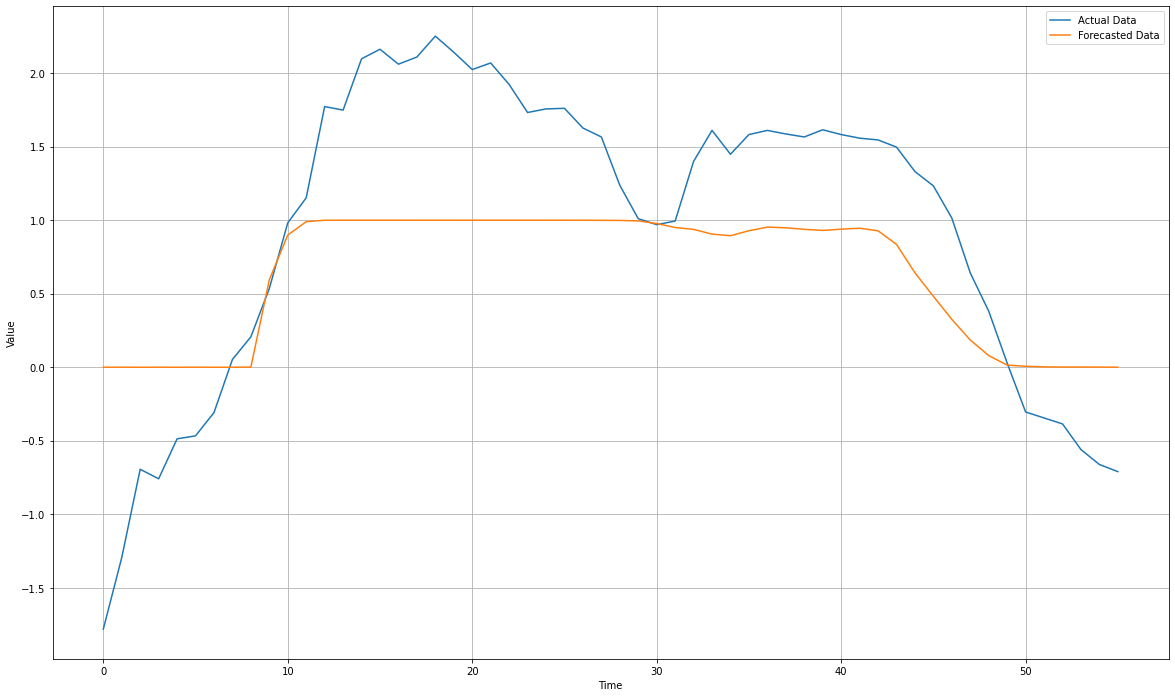

In [ ]:
plt.figure(figsize=(20, 12))
plt.plot(myTrainY[5])
plt.plot(forecast[5])
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend(("Actual Data","Forecasted Data"))
plt.grid(True)